In [36]:
import os
import re
import json
import nltk
import string

import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.metrics import confusion_matrix

In [ ]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('wordnet')

In [37]:
dat = pd.read_csv('train.csv')

In [38]:
dat

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


# EDA

Cleaning up the tweet data

In [39]:
# Duplicate tweets with different target variables
dt_counts = dat.groupby('text').target.count()[np.logical_and(dat.groupby('text').target.mean() > 0, dat.groupby('text').target.mean() < 1)]
dt_mean = dat.groupby('text').target.mean()[np.logical_and(dat.groupby('text').target.mean() > 0, dat.groupby('text').target.mean() < 1)]
dt_df = pd.DataFrame({'counts': dt_counts.values, 'avg_target': dt_mean})
dt_df

,counts,avg_target
text,,
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,3,0.333333
#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,3,0.666667
.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,4,0.750000
CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,3,0.666667
Caution: breathing may be hazardous to your health.,2,0.500000
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,6,0.333333
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife,3,0.333333
Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!,2,0.500000
I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????,2,0.500000


In [40]:
# Remove all but one duplicate
dat = dat.drop_duplicates(subset='text', keep="first")

In [41]:
dat

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1
7605,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1


In [42]:
# Tweet processing files
with open('slang.json') as json_file:
    slang_dict = json.load(json_file)
    
with open('contractions.json') as json_file:
    contraction_dict = json.load(json_file)
    
with open('stop_words.json') as json_file:
    stopwords_dict = json.load(json_file)

In [43]:
# Processing function from https://www.kaggle.com/ghaithkhlifi/zindi-competition-ensemble-models-tweet-prediction#Preprocessing

# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return slang_dict[word.lower()] if word.lower() in slang_dict.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "
    string = string[:-1]
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Remove all emojis, replace by EMOJI
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
                           "]+", flags=re.UNICODE)
    return(emoji_pattern.sub(r'EMOJI', text))

# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

# Factorize elongated words, add ELONG
def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)

# Factorize repeated punctuation, add REPEAT
def remove_repeat_punct(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)

# Remove all punctuations
def remove_all_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

# Remove punctuations
def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" 
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')   
    return text

# Remove all english stopwords
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
    return text

In [44]:
def clean_text(text):
    
    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    
    # Lower text, replace abbreviations
    text = text.lower()
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)
    
    # Remove emojis / smileys
    text = remove_emojis(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    
    # Remove repeated puntuations / words
    text = remove_elongated_words(text)
    text = remove_repeat_punct(text)
    
    text = remove_stopwords(text)
    text = remove_all_punct(text)
    #text = remove_punct(text)

    return text

In [45]:
dat['cleaned_text'] = dat['text'].apply(clean_text)

<ipython-input-45-8913baa9b6d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['cleaned_text'] = dat['text'].apply(clean_text)


In [46]:
for i in range(5):
    print(f'Original: {dat.iloc[i].text}')
    print(f'Cleaned: {dat.iloc[i].cleaned_text} \n')    

Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Cleaned: deeds reason earthquake may allah forgive us 

Original: Forest fire near La Ronge Sask. Canada
Cleaned: forest fire near la ronge sask canada 

Original: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Cleaned: residents asked shelter place notified officers evacuation shelter place orders expected 

Original: 13,000 people receive #wildfires evacuation orders in California 
Cleaned: NUMBER people receive wildfires evacuation orders california 

Original: Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
Cleaned: got sent photo ruby alaska smoke wildfires pours school 



In [47]:
vocab = []
for t in dat.cleaned_text:
    vocab += t.split(' ')
vocab_df = pd.DataFrame({'Word': vocab})
vocab = list(set(vocab))

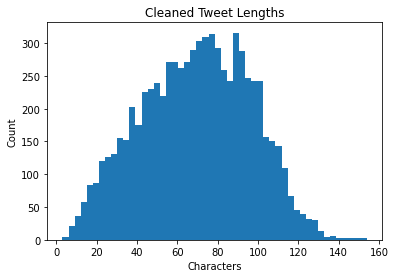

In [48]:
#sns.displot(dat['cleaned_text'].apply(len))
plt.hist(dat.cleaned_text.apply(len), bins=50)
plt.title('Cleaned Tweet Lengths')
plt.xlabel('Characters')
plt.ylabel('Count')
plt.show()

In [49]:
# Proportion of total words used
pd.DataFrame(vocab_df.value_counts() / vocab_df.shape[0]).head(10)

,0
Word,
url,0.058585
USER,0.033612
,0.025463
REPEAT,0.021902
NUMBER,0.021651
like,0.004288
im,0.003761
amp,0.003711
fire,0.003109


## Lemmatization and Stemming

Lemmatize and stem words in effort to improve model performance

In [50]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
 
def lemma_stem(text):
    trimmed_words = []
    for w in text.split():
        temp = lemmatizer.lemmatize(w)
        temp = stemmer.stem(temp)
        trimmed_words.append(temp)
    string = ""
    for word in trimmed_words:
        string += word_abbrev(word) + " "
    string = string[:-1]
    return(string)

In [51]:
dat['cleaned_text'] = dat['cleaned_text'].apply(lemma_stem)
dat

<ipython-input-51-024797ddb8d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['cleaned_text'] = dat['cleaned_text'].apply(lemma_stem)


,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv you
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,number peopl receiv wildfir evacu order califo...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...
...,...,...,...,...,...,...
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1,worldnew fallen powerlin glink tram updat fire...
7605,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1,flip side im walmart bomb everyon evacu stay t...
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,suicid bomber kill number saudi secur site mos...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant crane hold bridg collaps nearbi home...


In [52]:
vocab = []
for t in dat.cleaned_text:
    vocab += t.split(' ')
vocab_df = pd.DataFrame({'Word': vocab})
vocab = list(set(vocab))

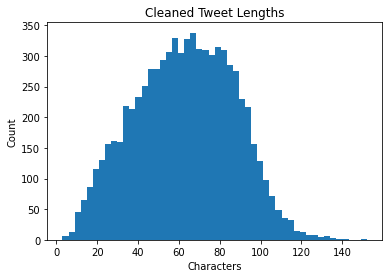

In [53]:
plt.hist(dat.cleaned_text.apply(len), bins=50)
plt.title('Cleaned Tweet Lengths')
plt.xlabel('Characters')
plt.ylabel('Count')
plt.show()

# RNN

The first model used for tweet classification will be a RNN

In [54]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=len(vocab))
encoder.adapt(vocab)

In [56]:
rnn_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [57]:
rnn_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['AUC'])

In [58]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history = rnn_model.fit(dat.text, dat.target, validation_split=0.1, epochs=4, callbacks=[callback])

Epoch 1/4
211/211 [==============================] - 13s 31ms/step - loss: 0.6862 - auc: 0.5068 - val_loss: 0.6851 - val_auc: 0.6445
Epoch 2/4
211/211 [==============================] - 4s 18ms/step - loss: 0.6374 - auc: 0.7185 - val_loss: 0.6002 - val_auc: 0.7710
Epoch 3/4
211/211 [==============================] - 4s 18ms/step - loss: 0.5197 - auc: 0.8235 - val_loss: 0.5377 - val_auc: 0.7982
Epoch 4/4
211/211 [==============================] - 4s 18ms/step - loss: 0.4388 - auc: 0.8740 - val_loss: 0.5245 - val_auc: 0.8023


In [59]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 0.6985515758395195)

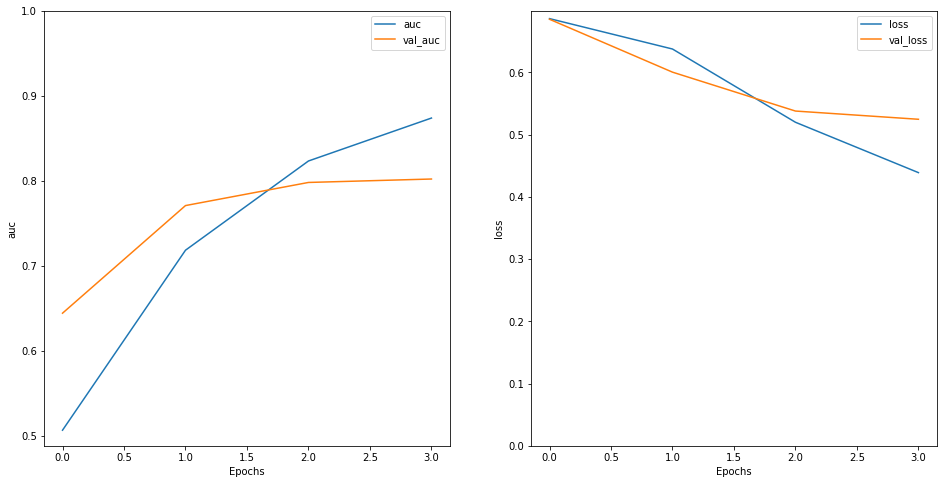

In [60]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'auc')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

# GBR

The second model used for classification will be a Gradient Boosted Classifier

In [138]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dat.cleaned_text)
Y = dat.target
print(X.shape)

(7503, 11715)


In [139]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [140]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_smote_train, y_smote_train = oversample.fit_resample(x_train, y_train)

In [141]:
from sklearn.ensemble import GradientBoostingClassifier

gbr_model = GradientBoostingClassifier()
gbr_model.fit(x_train, y_train)

GradientBoostingClassifier()

In [142]:
from sklearn.metrics import classification_report
print(classification_report(y_test, gbr_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.73      0.92      0.82       863
           1       0.84      0.54      0.66       638

    accuracy                           0.76      1501
   macro avg       0.79      0.73      0.74      1501
weighted avg       0.78      0.76      0.75      1501



In [143]:
cf_matrix = confusion_matrix(y_test, gbr_model.predict(x_test))
print(cf_matrix)

[[797  66]
 [293 345]]


<AxesSubplot:>

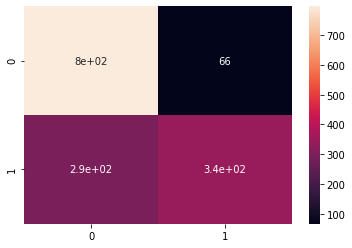

In [144]:
cf_matrix = confusion_matrix(y_test, gbr_model.predict(x_test))
sns.heatmap(cf_matrix, annot=True)

# Logistic Regression

Use logistic regression to make predictions

In [152]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dat.cleaned_text)
Y = dat.target
print(X.shape)

(7503, 11715)


In [153]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [154]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_smote_train, y_smote_train = oversample.fit_resample(x_train, y_train)

In [155]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)

LogisticRegression()

In [156]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lr_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       871
           1       0.85      0.64      0.73       630

    accuracy                           0.80      1501
   macro avg       0.82      0.78      0.79      1501
weighted avg       0.81      0.80      0.80      1501



In [157]:
cf_matrix = confusion_matrix(y_test, lr_model.predict(x_test))
print(cf_matrix)

[[801  70]
 [226 404]]


<AxesSubplot:>

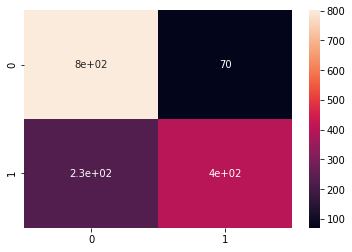

In [158]:
sns.heatmap(cf_matrix, annot=True)

# Submission Predictions

Make predictions on the submission data set using a trained model

In [145]:
test_dat = pd.read_csv('test.csv')

In [146]:
test_dat['cleaned_text'] = test_dat['text'].apply(clean_text)
test_dat['cleaned_text'] = test_dat['cleaned_text'].apply(lemma_stem)

In [147]:
test_dat.head()

,id,keyword,location,text,cleaned_text
0,0,NaN,NaN,Just happened a terrible car crash,happen terribl car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquak differ citi stay safe everyon
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond goos flee across street ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalyps light spokan wildfir
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill number china taiwan


In [159]:
test_dat_x = vectorizer.transform(test_dat.cleaned_text)

In [168]:
rnn_predictions = rnn_model.predict(test_dat.text)
predictions = rnn_predictions
prediction_labels = 1 * (predictions > 0.5)
pred_lst = []
for p in prediction_labels:
    pred_lst.append(p[0])

In [169]:
output_df = pd.DataFrame({'id': test_dat.id, 'target': pred_lst})

In [165]:
output_df.to_csv('jdym_submission.csv', index=False)